In [1]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l1_l2
import matplotlib.pyplot as plt
import seaborn as sns
import shutil

In [2]:
DATA_PATH = os.path.join('../Assets/Dataset_LSTM')
actions = np.array(['xin_chao', 'cam_on', 'xin_loi', 'toi_khoe'])
no_sequences = 30
sequence_length = 30

In [3]:
label_mapping = {
    'xin_chao': 'xin chào',
    'cam_on': 'cảm ơn',
    'xin_loi': 'xin lỗi',
    'toi_khoe': 'tôi khoẻ'
}

# Tạo label map cho huấn luyện (dùng tên file)
label_map = {label: num for num, label in enumerate(actions)}
print("Label map:", label_map)

# Tạo label map tiếng Việt có dấu
vietnamese_labels = [label_mapping[action] for action in actions]
print("Vietnamese labels:", vietnamese_labels)

Label map: {'xin_chao': 0, 'cam_on': 1, 'xin_loi': 2, 'toi_khoe': 3}
Vietnamese labels: ['xin chào', 'cảm ơn', 'xin lỗi', 'tôi khoẻ']


In [4]:
sequences, labels = [], []
missing_count = 0  # Đếm số file bị thiếu để kiểm tra

for action in actions:
    for sequence in range(no_sequences):
        window = []
        valid_sequence = True  # Cờ kiểm tra đủ frame trong sequence
        for frame_num in range(sequence_length):
            file_path = os.path.join(DATA_PATH, action, str(sequence), f"{frame_num}.npy")
            if os.path.exists(file_path):
                res = np.load(file_path)
                window.append(res)
            else:
                print(f"⚠️  Thiếu file: {file_path}")
                missing_count += 1
                valid_sequence = False
                break  # Bỏ qua sequence này nếu thiếu frame
        if valid_sequence:
            sequences.append(window)
            labels.append(label_map[action])

print(f"Tổng số sequences hợp lệ: {len(sequences)}")
print(f"Tổng số labels: {len(labels)}")
print(f"Shape của mỗi sequence: {np.array(sequences).shape}")
print(f"Tổng số sequences bị bỏ qua do thiếu file: {missing_count}")


⚠️  Thiếu file: ../Assets/Dataset_LSTM\xin_chao\4\1.npy
⚠️  Thiếu file: ../Assets/Dataset_LSTM\toi_khoe\0\0.npy
⚠️  Thiếu file: ../Assets/Dataset_LSTM\toi_khoe\1\0.npy
⚠️  Thiếu file: ../Assets/Dataset_LSTM\toi_khoe\6\3.npy
Tổng số sequences hợp lệ: 116
Tổng số labels: 116
Shape của mỗi sequence: (116, 30, 1692)
Tổng số sequences bị bỏ qua do thiếu file: 4


In [5]:
X = np.array(sequences)
y = to_categorical(labels).astype(int)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (116, 30, 1692)
y shape: (116, 4)


In [6]:
# Data Augmentation - Thêm noise nhẹ
def add_noise(data, noise_factor=0.01):
    noise = np.random.normal(0, noise_factor, data.shape)
    return data + noise

# Tạo thêm dữ liệu với noise
X_augmented = []
y_augmented = []
for i in range(len(X)):
    # Dữ liệu gốc
    X_augmented.append(X[i])
    y_augmented.append(y[i])
    
    # Thêm 2 version với noise khác nhau
    X_augmented.append(add_noise(X[i], 0.005))
    y_augmented.append(y[i])
    
    X_augmented.append(add_noise(X[i], 0.01))
    y_augmented.append(y[i])

X_augmented = np.array(X_augmented)
y_augmented = np.array(y_augmented)

print(f"Sau augmentation - X shape: {X_augmented.shape}")
print(f"Sau augmentation - y shape: {y_augmented.shape}")

Sau augmentation - X shape: (348, 30, 1692)
Sau augmentation - y shape: (348, 4)


In [7]:
# Chia dữ liệu train/test với stratify
X_train, X_test, y_train, y_test = train_test_split(
    X_augmented, y_augmented, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_augmented
)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (278, 30, 1692)
X_test shape: (70, 30, 1692)


In [8]:
# Tính class weights để xử lý imbalanced data
y_train_classes = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train_classes),
    y=y_train_classes
)
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)

Class weights: {0: 1.0072463768115942, 1: 0.9652777777777778, 2: 0.9652777777777778, 3: 1.0692307692307692}


In [11]:
log_dir = "/mnt/data/logs/train"
os.makedirs(log_dir, exist_ok=True)

tb_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)



In [12]:
# Hàm tạo mô hình LSTM cải tiến
def create_improved_model(input_shape):
    model = Sequential()
    
    # Layer 1: LSTM với regularization
    model.add(LSTM(32, return_sequences=True, activation='tanh', 
                   input_shape=input_shape,
                   kernel_regularizer=l1_l2(l1=0.01, l2=0.01),
                   recurrent_regularizer=l1_l2(l1=0.01, l2=0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    # Layer 2: LSTM
    model.add(LSTM(64, return_sequences=True, activation='tanh',
                   kernel_regularizer=l1_l2(l1=0.01, l2=0.01),
                   recurrent_regularizer=l1_l2(l1=0.01, l2=0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    
    # Layer 3: LSTM
    model.add(LSTM(32, return_sequences=False, activation='tanh',
                   kernel_regularizer=l1_l2(l1=0.01, l2=0.01),
                   recurrent_regularizer=l1_l2(l1=0.01, l2=0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    
    # Dense layers với regularization
    model.add(Dense(32, activation='relu', 
                    kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(16, activation='relu',
                    kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
    model.add(Dropout(0.3))
    
    # Output layer
    model.add(Dense(actions.shape[0], activation='softmax'))
    
    return model

# Tạo model
model = create_improved_model((sequence_length, X_train.shape[2]))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 32)            220800    
                                                                 
 batch_normalization (Batch  (None, 30, 32)            128       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 30, 32)            0         
                                                                 
 lstm_1 (LSTM)               (None, 30, 64)            24832     
                                                                 
 batch_normalization_1 (Bat  (None, 30, 64)            256       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 30, 64)            0

In [13]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=10,
    min_lr=1e-8,
    verbose=1
)

In [186]:
print("\nBắt đầu huấn luyện...")
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=16,
    validation_data=(X_test, y_test),
    class_weight=class_weight_dict,
    callbacks=[tb_callback, early_stopping, reduce_lr],
    verbose=1
)


Bắt đầu huấn luyện...
Epoch 1/20
18/18 [==============================] - 2s 80ms/step - loss: 24.2609 - categorical_accuracy: 0.8201 - val_loss: 23.7256 - val_categorical_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 2/20
18/18 [==============================] - 1s 71ms/step - loss: 23.7945 - categorical_accuracy: 0.8453 - val_loss: 23.3391 - val_categorical_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 3/20
18/18 [==============================] - 1s 71ms/step - loss: 23.4294 - categorical_accuracy: 0.8453 - val_loss: 22.9309 - val_categorical_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 4/20
18/18 [==============================] - 1s 72ms/step - loss: 23.0246 - categorical_accuracy: 0.8525 - val_loss: 22.7641 - val_categorical_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 5/20
18/18 [==============================] - 1s 71ms/step - loss: 22.6412 - categorical_accuracy: 0.8669 - val_loss: 22.9619 - val_categorical_accuracy: 0.7571 - lr: 1.0000e-04
Epoch 6/20
18/18 [==============================] - 1s 72

In [187]:
model_path = 'model_lstm.h5'
model.save(model_path)
print(f"\nModel đã được lưu tại: {model_path}")


Model đã được lưu tại: model_lstm.h5


In [16]:
print("\nĐánh giá model:")
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Đánh giá model:
Test Loss: 55.6223
Test Accuracy: 0.8429


In [17]:
# Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

3/3 [==============================] - 2s 22ms/step


In [18]:
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f"Accuracy Score: {accuracy:.4f}")

Accuracy Score: 0.8429


In [19]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_true_classes, y_pred_classes)
print("\nConfusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=vietnamese_labels))


Confusion Matrix:
[[18  0  0  0]
 [ 0 15  0  3]
 [ 0  8 10  0]
 [ 0  0  0 16]]

Classification Report:
              precision    recall  f1-score   support

    xin chào       1.00      1.00      1.00        18
      cảm ơn       0.65      0.83      0.73        18
     xin lỗi       1.00      0.56      0.71        18
    tôi khoẻ       0.84      1.00      0.91        16

    accuracy                           0.84        70
   macro avg       0.87      0.85      0.84        70
weighted avg       0.87      0.84      0.84        70



In [24]:
# Vẽ biểu đồ training history
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot training & validation accuracy
    ax1.plot(history.history['categorical_accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)
    
    # Plot training & validation loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

In [25]:
# Vẽ confusion matrix
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

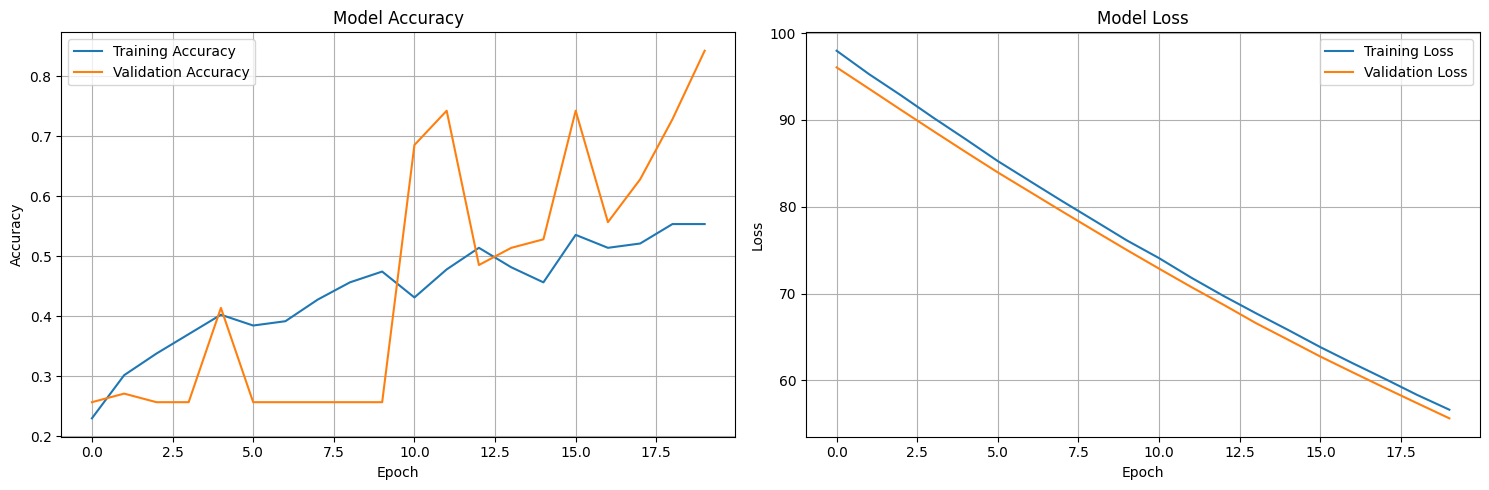

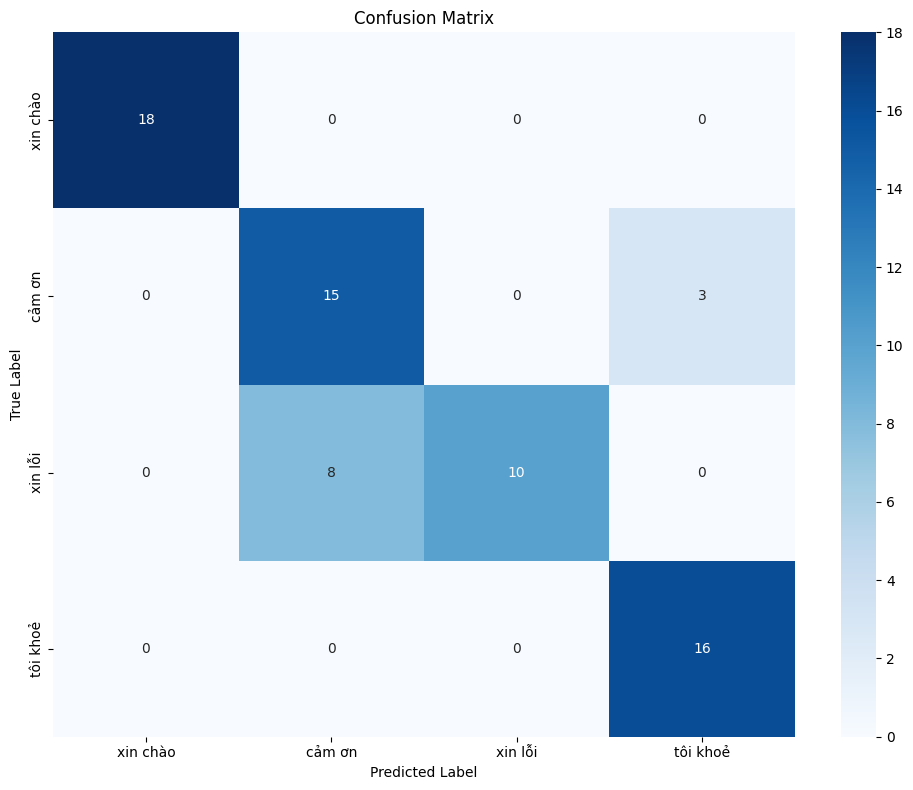


Huấn luyện hoàn tất!
Model đã được lưu: model_lstm.h5
Các file biểu đồ đã được lưu: training_history.png, confusion_matrix.png


In [26]:
# Vẽ biểu đồ
plot_training_history(history)
plot_confusion_matrix(cm, vietnamese_labels)

print("\nHuấn luyện hoàn tất!")
print(f"Model đã được lưu: {model_path}")
print("Các file biểu đồ đã được lưu: training_history.png, confusion_matrix.png")

In [ ]:
# Lưu actions array để sử dụng sau
np.save('actions.npy', actions)
print("Actions array đã được lưu: actions.npy")

Actions array đã được lưu: actions.npy


In [190]:
# Test với một số mẫu ngẫu nhiên
print("\nTest với một số mẫu ngẫu nhiên:")
for i in range(5):
    idx = np.random.randint(0, len(X_test))
    prediction = model.predict(X_test[idx:idx+1])
    predicted_class = np.argmax(prediction)
    true_class = np.argmax(y_test[idx])
    confidence = np.max(prediction)
    
    is_correct = predicted_class == true_class
    result = "✓ Đúng" if is_correct else "X Sai"
    
    print(f"Mẫu {i+1}: Dự đoán='{actions[predicted_class]}' (confidence: {confidence:.3f}), "
          f"Thực tế='{actions[true_class]}', "
          f"Kết quả: {result}")



Test với một số mẫu ngẫu nhiên:
1/1 [==============================] - 0s 84ms/step
Mẫu 1: Dự đoán='toi_khoe' (confidence: 0.903), Thực tế='toi_khoe', Kết quả: ✓ Đúng
1/1 [==============================] - 0s 50ms/step
Mẫu 2: Dự đoán='xin_loi' (confidence: 0.981), Thực tế='xin_loi', Kết quả: ✓ Đúng
1/1 [==============================] - 0s 49ms/step
Mẫu 3: Dự đoán='xin_loi' (confidence: 0.676), Thực tế='cam_on', Kết quả: X Sai
1/1 [==============================] - 0s 54ms/step
Mẫu 4: Dự đoán='xin_loi' (confidence: 0.981), Thực tế='xin_loi', Kết quả: ✓ Đúng
1/1 [==============================] - 0s 41ms/step
Mẫu 5: Dự đoán='xin_loi' (confidence: 0.984), Thực tế='xin_loi', Kết quả: ✓ Đúng
